In [1]:
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

%matplotlib inline

In [2]:
#export
from exp.pm4py import *

In [3]:
#export
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from functools import partial,update_wrapper


# Base Petrinet

In [4]:
trans=['T1','T2','T3','T4']
places=['P1','P2','P3','P4','P5','P6']

In [5]:


D_plus=np.array([
    [0,1,  1,  0,  0,  0],
    [0,0,  0,  1,  1,  0],
    [0,0,  0,  0,  1,  0],
    [0,0,  0,  0,  0,  1],
]);D_plus

array([[0, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

In [6]:
D_minus=np.array([
    [1,0, 0, 0, 0, 0],
    [0,1,  0,  0,  0,  0],
    [0,0,  1,  0,  0,  0],
    [0,0,  0,  1,  1,  0],
    
]);D_minus

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 0]])

In [7]:
M=[1, 0, 0, 0, 0, 0]

In [8]:
D=D_plus-D_minus
D

array([[-1,  1,  1,  0,  0,  0],
       [ 0, -1,  0,  1,  1,  0],
       [ 0,  0, -1,  0,  1,  0],
       [ 0,  0,  0, -1, -1,  1]])

In [9]:
(M>=D_minus).all(axis=1)

array([ True, False, False, False])

In [10]:
b = np.array([1, 0, 0, 0,0,0])



In [11]:
a=np.matmul(D_minus, b)
a=np.sign(a)

In [12]:
def next_marking(a,b):
  
    x=np.matmul(a, D)+b
    return x
b

array([1, 0, 0, 0, 0, 0])

In [13]:
class PetriNet:
    def __init__(self,P,T,I,O,m0):
        self.P,self.T,self.I,self.O,self.m0=np.array(P),np.array(T),np.array(I),np.array(O),np.array(m0)
        self.Ic=O-I
        self.reset()
    
    def transition(self,event):
        t=self.T==event
        self.m=np.matmul(t, self.Ic)+self.m
        
    def reset(self):
        self.m=self.m0

# View

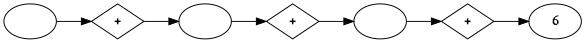

In [14]:
G = nx.DiGraph()
G.graph['rankdir'] = 'LR'
G.graph['dpi'] = 70
labels=['A','B','C','D','E','F']
for i in [0,2,4]:
    G.add_node(i,label=' ')
    G.add_node(i+1,size=150,label='+',shape='diamond')
    G.add_edge(i,i+1)
    G.add_edge(i+1,i+2)


draw(G)

In [15]:
def view(x=0):
    b=[1,0,0,0,0,0]

    if x!=0:
        for i in range(x):
            a=(b>=D_minus).all(axis=1)
            b=next_marking(a,b)
            
        tokens=list(b)
        for i in range(len(tokens)):
            if tokens[i]==0:
                tokens[i]=' '
        
    else:
        tokens=['1',' ',' ',' ',' ',' ']
       
    G = nx.DiGraph()
    G.graph['rankdir'] = 'LR'
    G.graph['dpi'] = 70
    print('M:',b)
    

    for i in range(len(trans)):
        G.add_node(trans[i],shape='square',style='filled',fillcolor='grey',label=trans[i])
    for i in range(len(places)):
        if i==0: G.add_node(places[i],label=tokens[i],style='filled',fillcolor='green')
        elif i==len(places)-1: G.add_node(places[i],label=tokens[i],style='filled',fillcolor='red')
        else: G.add_node(places[i],label=tokens[i])

    for i in range(len(trans)):
        for j in range(len(places)):
            #print(D_plus[i,j])
            if D_minus[i,j]==1:
                G.add_edge(places[j],trans[i])
            #print(D_plus[i,j])
            if D_plus[i,j]==1:
                G.add_edge(trans[i],places[j])


    return draw(G)

In [16]:
def animate():
    return interact(view,x=widgets.IntSlider(min=0, max=3, step=1, value=0))
animate()

interactive(children=(IntSlider(value=0, description='x', max=3), Output()), _dom_classes=('widget-interact',)…

<function __main__.view(x=0)>

In [17]:
class PetriNet:
    def __init__(self,P,T,I,O,m0):
        self.P,self.T,self.I,self.O,self.m0=np.array(P),np.array(T),np.array(I),np.array(O),np.array(m0)
        self.Ic=O-I
        self.reset()
    
    def transition(self,event):
        t=self.T==event
        self.m=np.matmul(t, self.Ic)+self.m
        
    def reset(self):
        self.m=self.m0
    
    def view(self):
        
        G = nx.DiGraph()
        G.graph['rankdir'] = 'LR'
        G.graph['dpi'] = 70
        for i in range(len(self.T)):
            if self.T[i].startswith('_'):
                G.add_node(self.T[i],label=' ',shape='square',style='filled',fillcolor='black')
            else:
                G.add_node(self.T[i],shape='square',style='filled',fillcolor='grey',label=self.T[i].split('_')[0])
        for i in range(len(self.P)):
            label=self.m[i] if self.m[i] else ' '
            if i==0: G.add_node(self.P[i],label=label,style='filled',fillcolor='green')
            elif i==len(self.P)-1: G.add_node(self.P[i],label=label,style='filled',fillcolor='red')
            else: G.add_node(self.P[i],label=label)

        for i in range(len(self.T)):
            for j in range(len(self.P)):
                #print(D_plus[i,j])
                if self.I[i,j]==1:
                    G.add_edge(self.P[j],self.T[i])
                #print(D_plus[i,j])
                if self.O[i,j]==1:
                    G.add_edge(self.T[i],self.P[j])

        return draw(G)
    
   
    def _animate(self,trace,x=0):
        self.reset()
        event=0
        for i in range(x):
            event=trace[i]
            self.transition(event)
        if x!=0:print(event)
        return self.view()
    
    def animate(self,trace):
        print(trace)
        return interact(self._animate,trace=fixed(trace),x=widgets.IntSlider(min=0, max=len(trace), step=1, value=0))

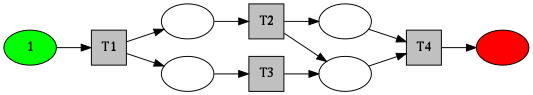

In [18]:
p=PetriNet(places,trans,D_minus,D_plus,[1,0,0,0,0,0])
p.view()

In [20]:
p.animate(['T1','T1','T3','T4'])

['T1', 'T1', 'T3', 'T4']


interactive(children=(IntSlider(value=0, description='x', max=4), Output()), _dom_classes=('widget-interact',)…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

# Create from simple grammar

In [ ]:
s=['->A','A->B,C','B,C->D','B->E','D->E,F','E,F->I','C->_1,G','_1,G->H','H->F','I->']

def create(s):
    
    def t_in_trans(i,t,rel):
        res=False
        r=rel.split('->')[i]
        for j in r.split(','): 
            if j==t: res=True
        return res
        
    trans=set()
    for t in s:
        inp,out=t.split('->')
        for i in inp.split(','): trans.add(i)
        for i in out.split(','): trans.add(i)
    trans=list(trans)
    
    places=list(range(len(s)))
    trans.remove('')

    I=np.zeros(((len(trans),len(places))))
    O=np.zeros(((len(trans),len(places))))
    for p in range(len(places)):
        for t in range(len(trans)):
            if t_in_trans(0,trans[t],s[p]): O[t,p]+=1
            if t_in_trans(1,trans[t],s[p]): I[t,p]+=1
    m0=[0 for i in s]
    m0[0]=1
    return places,trans,I,O,m0

tu=create(s)
p=PetriNet(*tu)
p.view()

In [21]:
#export
class PetriNet:
    def __init__(self,P,T,I,O,m0):
        self.P,self.T,self.I,self.O,self.m0=np.array(P),np.array(T),np.array(I),np.array(O),np.array(m0)
        self.Ic=O-I
        self.reset()
    def view(self):
        
        G = nx.DiGraph()
        G.graph['rankdir'] = 'LR'
        G.graph['dpi'] = 70
        for i in range(len(self.T)):
            if self.T[i].startswith('_'):
                G.add_node(self.T[i],label=' ',shape='square',style='filled',fillcolor='black')
            else:
                G.add_node(self.T[i],shape='square',style='filled',fillcolor='grey',label=self.T[i].split('_')[0])
        for i in range(len(self.P)):
            label=self.m[i] if self.m[i] else ' '
            if i==0: G.add_node(self.P[i],label=label,style='filled',fillcolor='green')
            elif i==len(self.P)-1: G.add_node(self.P[i],label=label,style='filled',fillcolor='red')
            else: G.add_node(self.P[i],label=label)

        for i in range(len(self.T)):
            for j in range(len(self.P)):
                #print(D_plus[i,j])
                if self.I[i,j]==1:
                    G.add_edge(self.P[j],self.T[i])
                #print(D_plus[i,j])
                if self.O[i,j]==1:
                    G.add_edge(self.T[i],self.P[j])

        return draw(G)
    
    def transition(self,event):
        t=self.T==event
        self.m=np.matmul(t, self.Ic)+self.m
        
    def reset(self):
        self.m=self.m0
    def _animate(self,trace,x=0):
        self.reset()
        event=0
        for i in range(x):
            event=trace[i]
            self.transition(event)
        if x!=0:print(event)
        return self.view()
   
    @classmethod
    def from_simple_grammar(cls,s:list):

        def t_in_trans(i,t,rel):
            res=False
            r=rel.split('->')[i]
            for j in r.split(','): 
                if j==t: res=True
            return res

        trans=set()
        for t in s:
            inp,out=t.split('->')
            for i in inp.split(','): trans.add(i)
            for i in out.split(','): trans.add(i)
        trans=list(trans)

        places=list(range(len(s)))
        trans.remove('')

        I=np.zeros(((len(trans),len(places))))
        O=np.zeros(((len(trans),len(places))))
        for p in range(len(places)):
            for t in range(len(trans)):
                if t_in_trans(0,trans[t],s[p]): O[t,p]+=1
                if t_in_trans(1,trans[t],s[p]): I[t,p]+=1
        m0=[0 for i in s]
        m0[0]=1
        return PetriNet(places,trans,I,O,m0)

    
    def animate(self,trace):
        print(trace)
        return interact(self._animate,trace=fixed(trace),x=widgets.IntSlider(min=0, max=len(trace), step=1, value=0))

In [22]:
#export
nets=[
    ['->A','A->B,C','B,C->D','B->E','D->E,F','E,F->I','C->_1,G','_1,G->H','H->F','I->'],
    ['->A','A->B','B->D','D->E','E->I','I->'],
    ['->_1','_1,A,B,C,D,E,F,G,H,I->_2,A,B,C,D,E,F,G,H,I','_2->'],
    ['->A_1,A_2,A_3,A_4,A_5',
     'A_1->B','B->D_1','D_1->E','E->I_1',
     'A_2->C_1','C_1->D_2','D_2->G_1','G_1->H_1','H_1->F_1','F_1->I_2',
     'A_3->C_2','C_2->G_2','G_2->D_3','D_3->H_2','H_2->F_2','F_2->I_3',
     'A_4->C_3','C_3->H_3','H_3->D_4','D_4->F_3','F_3->I_4',
     'A_5->C_4','C_4->D_5','D_5->H_4','H_4->F_4','F_4->I_5',
     'I_1,I_2,I_3,I_4,I_5->'],
    ['->A','A->B,C','B,C->D','D->E,F','B->E','C->_1,G','_1,G->F','C->_2,H','_2,H->F','E,F->I','I->'],
    ['->A','A->B,C','B,C->D','D->E,F','B->E','E,F->I','C,G,H->G,H,F','I->'],
    ['->A','A->B,C','B,C,D->D,E,F','C->_1,G','_1,G->H','H->F','B->E','E,F->I','I->'],
    ['->_1','_1->A,B,C,D,E,F,G,H,I','A,B,C,D,E,F,G,H,I->_2','_2->']
    
]


1 : ['->A', 'A->B,C', 'B,C->D', 'B->E', 'D->E,F', 'E,F->I', 'C->_1,G', '_1,G->H', 'H->F', 'I->']


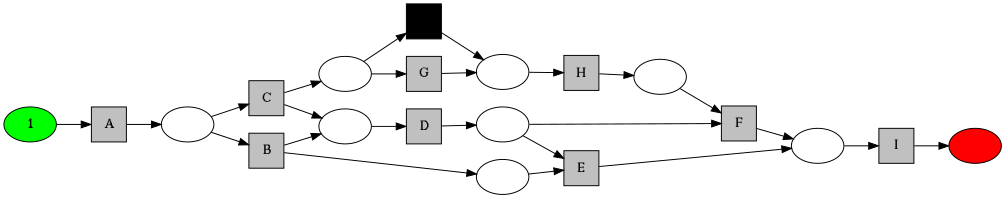

2 : ['->A', 'A->B', 'B->D', 'D->E', 'E->I', 'I->']


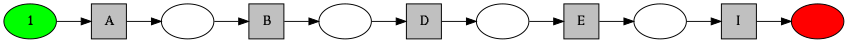

3 : ['->_1', '_1,A,B,C,D,E,F,G,H,I->_2,A,B,C,D,E,F,G,H,I', '_2->']


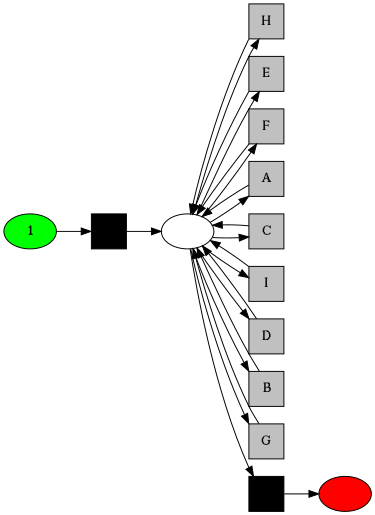

4 : ['->A_1,A_2,A_3,A_4,A_5', 'A_1->B', 'B->D_1', 'D_1->E', 'E->I_1', 'A_2->C_1', 'C_1->D_2', 'D_2->G_1', 'G_1->H_1', 'H_1->F_1', 'F_1->I_2', 'A_3->C_2', 'C_2->G_2', 'G_2->D_3', 'D_3->H_2', 'H_2->F_2', 'F_2->I_3', 'A_4->C_3', 'C_3->H_3', 'H_3->D_4', 'D_4->F_3', 'F_3->I_4', 'A_5->C_4', 'C_4->D_5', 'D_5->H_4', 'H_4->F_4', 'F_4->I_5', 'I_1,I_2,I_3,I_4,I_5->']


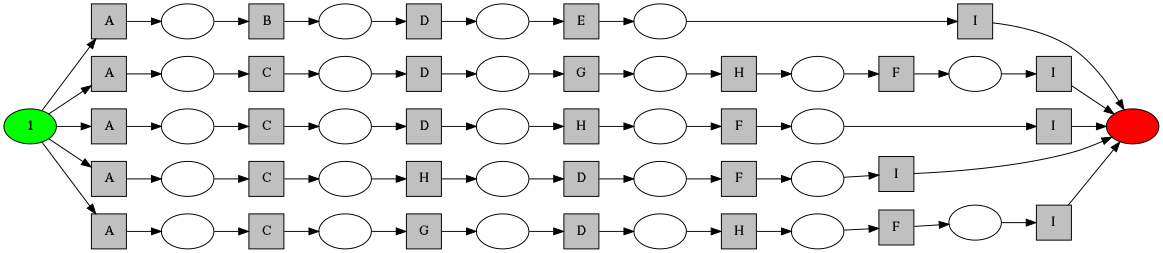

5 : ['->A', 'A->B,C', 'B,C->D', 'D->E,F', 'B->E', 'C->_1,G', '_1,G->F', 'C->_2,H', '_2,H->F', 'E,F->I', 'I->']


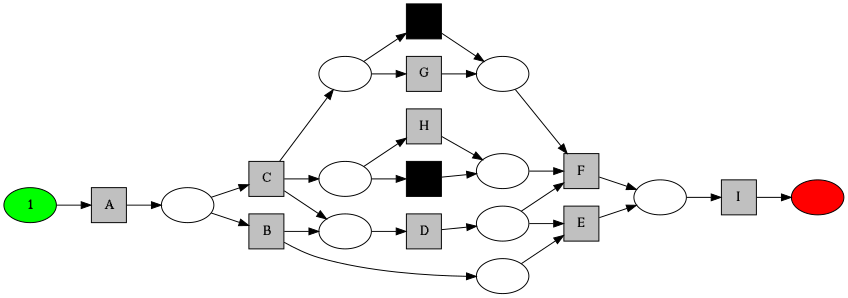

6 : ['->A', 'A->B,C', 'B,C->D', 'D->E,F', 'B->E', 'E,F->I', 'C,G,H->G,H,F', 'I->']


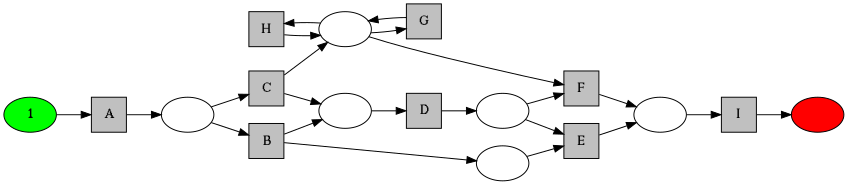

7 : ['->A', 'A->B,C', 'B,C,D->D,E,F', 'C->_1,G', '_1,G->H', 'H->F', 'B->E', 'E,F->I', 'I->']


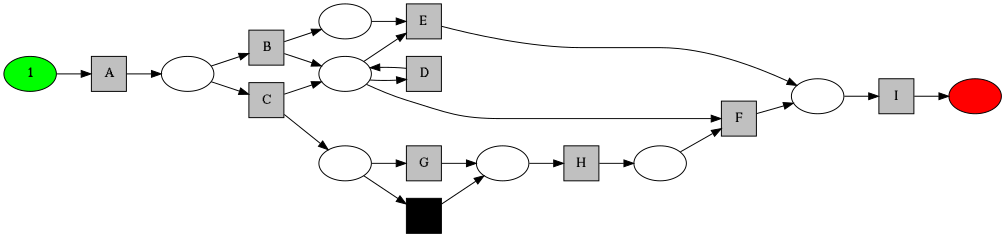

8 : ['->_1', '_1->A,B,C,D,E,F,G,H,I', 'A,B,C,D,E,F,G,H,I->_2', '_2->']


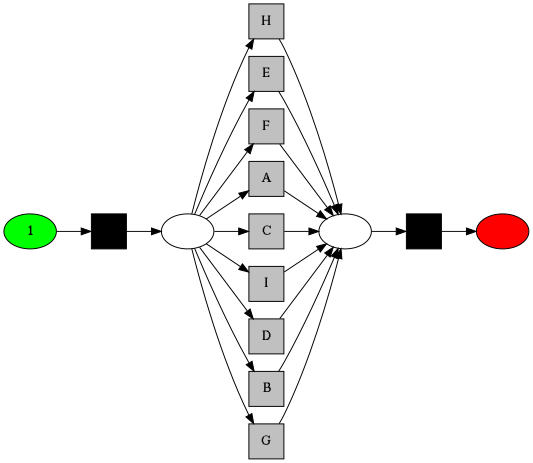

In [23]:
for i,n in enumerate(nets):
    print(i+1,':',n)
    p=PetriNet.from_simple_grammar(n)
    display(p.view())

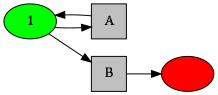

In [24]:
PetriNet.from_simple_grammar(['A->A,B','B->']).view()

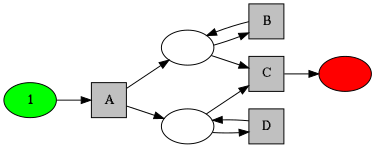

In [25]:
PetriNet.from_simple_grammar(['->A','A,B->B,C','A,D->D,C','C->']).view()

In [28]:
PetriNet.from_simple_grammar(['->A','A,B->B,C','A,D->D,C','C->A','B->C']).animate(['A','B','B'])

['A', 'B', 'B']


interactive(children=(IntSlider(value=0, description='x', max=3), Output()), _dom_classes=('widget-interact',)…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

# Import

# Export 

# Generate Pythom

In [ ]:
! /home/lahann/anaconda3/envs/fastpm/bin/python notebook2script.py 05_fastpm_petrinet.ipynb

# Memory Tests

In [ ]:
%memit a=np.random.rand(100,300,300)

In [ ]:
%memit sa=np.random.rand(100,300,300)

In [ ]:
%memit sas,sa,a=0,0,0